# Airbnb Big Data Project:

## Introduction:

[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

# Objectives:

## Part 1: Loading, describing and preparing the data

## Par 2: Analysis

## Review Analysis


### Create Spark session and define imports

In [3]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
from dateutil.parser import parse
from pyspark.sql.functions import to_date
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.types import DateType
from pyspark.sql.types import DoubleType
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.functions import col, size, asc, desc
from pyspark.sql.functions import explode
from pyspark.sql.functions import udf


spark = SparkSession.builder.appName("Project Three").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [4]:
#Loading Data 
df = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape', '"').csv('listings.csv')

In [6]:
df.select('price').show(10)

+---------+
|    price|
+---------+
|$3,209.00|
|  $597.00|
|$1,106.00|
|  $969.00|
|$1,301.00|
|$1,663.00|
|  $401.00|
|  $499.00|
|  $861.00|
|$1,370.00|
+---------+
only showing top 10 rows



In [117]:
dftry = df
dftry1 = df

In [204]:
#Data description
#Checking Attributes and Rows
print('number of rows:'+ str(df.count()))
print('number of columns:'+ str(len(df.columns)))


number of rows:1330480
number of columns:106


In [205]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [1]:
#Column names of the dataframe 
df.schema.names.head()

NameError: name 'df' is not defined

The data contains 1330480 oservations and 106 attributes. From the output of the print.Schema, it cab be observed that data types are all in string. However, due to the analysis required, we have to change host_since datatype from string to date. Besides the host_since, price, review_scores_rating and host_total_listings_count datatype are changed from string to float as it can seen below.  

However, it can be seen that the price attribute have a dollar sign and must be removed. If the dollar sign sign is not remove and the datatype is converted to float, it will render the values of the price column to be null

In [258]:
#Removing the dollar sign in the price attribute 

charReplace=udf(lambda x: x.replace('$',''))

df=df.withColumn('price',charReplace('price'))

In [259]:
#Changing Data Types
dftry1= df.withColumn("host_since",df['host_since'].cast(DateType()))
dftry2 = dftry1.withColumn("price", df['price'].cast(FloatType()))
dftry3 = dftry2.withColumn("review_scores_rating", df['review_scores_rating'].cast(FloatType()))
df0 = dftry3.withColumn("host_total_listings_count", df['host_total_listings_count'].cast(FloatType()))




In [260]:
df.select('price').show(10)

+--------+
|   price|
+--------+
|1,272.00|
|1,203.00|
|3,209.00|
|  597.00|
|  734.00|
|  665.00|
|  890.00|
|  597.00|
|  558.00|
|  196.00|
+--------+
only showing top 10 rows



In [261]:
df0.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- host_location: string (nullable =

By inspection, it can seen that the datatype of the attributes of interest have been changed to the desired data type. 

In [269]:
#Staging data for referencing
df1 = df0.select('city', 'host_total_listings_count', 'property_type','neighbourhood','review_scores_rating','host_since','price')

In [270]:
df1.printSchema()

root
 |-- city: string (nullable = true)
 |-- host_total_listings_count: float (nullable = true)
 |-- property_type: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- review_scores_rating: float (nullable = true)
 |-- host_since: date (nullable = true)
 |-- price: float (nullable = true)



In [271]:
df1.show(10)

+---------+-------------------------+-----------------+-------------+--------------------+----------+-----+
|     city|host_total_listings_count|    property_type|neighbourhood|review_scores_rating|host_since|price|
+---------+-------------------------+-----------------+-------------+--------------------+----------+-----+
|Stockholm|                      1.0|        Apartment|    Södermalm|                97.0|2011-06-15| null|
|Stockholm|                      2.0|            House|    Skarpnäck|                null|2011-06-26| null|
|Stockholm|                      1.0|        Apartment|    Södermalm|                94.0|2011-06-27| null|
|Stockholm|                      2.0|        Apartment|    Södermalm|                97.0|2011-07-06|597.0|
|Stockholm|                      1.0|        Apartment|    Södermalm|                93.0|2011-07-13|734.0|
|Stockholm|                      1.0|Bed and breakfast|    Södermalm|                98.0|2011-08-26|665.0|
|Stockholm|                 

Part Two


In [274]:
df_listings_neighhood_per_city= df1.groupBy('city').agg(f.sum('host_total_listings_count'))

In [275]:
df_listings_neighhood_per_city.show(100)

+--------------------+------------------------------+
|                city|sum(host_total_listings_count)|
+--------------------+------------------------------+
|           Cape town|                          20.0|
|Plumstead, Cape town|                           1.0|
|     Río de janeiro |                           3.0|
|Saint-Médard-en-J...|                         309.0|
|             LYON 02|                          60.0|
|Paris-15E-Arrondi...|                         338.0|
|               75007|                          11.0|
|             Antwerp|                        7887.0|
| WATERMAEL BOITSFORT|                           1.0|
|             beyazıd|                           4.0|
|         kagirthâne |                           1.0|
|          Seyit Ömer|                           1.0|
|              Sopela|                          83.0|
|       Quejana-Ayala|                           1.0|
|            Lantaron|                           4.0|
|           Aperregui|      

In [278]:
df_selected_city = df1.filter(f.col( 'city') == 'Stockholm') 

In [279]:
df_selected_city.show(10)

+---------+-------------------------+-----------------+-------------+--------------------+----------+-----+
|     city|host_total_listings_count|    property_type|neighbourhood|review_scores_rating|host_since|price|
+---------+-------------------------+-----------------+-------------+--------------------+----------+-----+
|Stockholm|                      1.0|        Apartment|    Södermalm|                97.0|2011-06-15| null|
|Stockholm|                      2.0|            House|    Skarpnäck|                null|2011-06-26| null|
|Stockholm|                      1.0|        Apartment|    Södermalm|                94.0|2011-06-27| null|
|Stockholm|                      2.0|        Apartment|    Södermalm|                97.0|2011-07-06|597.0|
|Stockholm|                      1.0|        Apartment|    Södermalm|                93.0|2011-07-13|734.0|
|Stockholm|                      1.0|Bed and breakfast|    Södermalm|                98.0|2011-08-26|665.0|
|Stockholm|                 

In [295]:
df_neighhood_property_type = df1.groupBy('neighbourhood').agg(f.count('property_type'))

In [296]:
df_neighhood_property_type.show()

+--------------------+--------------------+
|       neighbourhood|count(property_type)|
+--------------------+--------------------+
|San Pablo/Santa J...|                 157|
|         Schmöckwitz|                  24|
|             Palermo|                6596|
|              Raheny|                  99|
|    Edogawa District|                  74|
|           Prague 13|                 105|
|Liuliqiao/Lize Br...|                 102|
|            Escandón|                 395|
|     Rancho Bernardo|                  58|
|    Fairmont Village|                  19|
|          Donaustadt|                 366|
|          Humbermede|                  20|
|           Tollcross|                 275|
|             Frogner|                 496|
|Opéra - Grands Bo...|                1110|
|           Apartment|                   1|
|     South Melbourne|                 314|
|            Satalice|                   6|
|            Huaxiang|                 216|
|          North Park|          

In [301]:
dat1  = df_neighhood_property_type.toPandas()

In [309]:
dat1.head(2)

,neighbourhood,count(property_type)
0,San Pablo/Santa Justa,157
1,Schmöckwitz,24


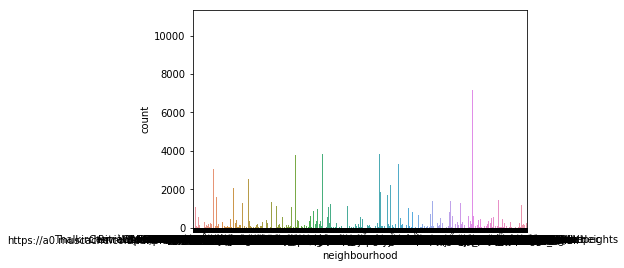

<Figure size 1440x720 with 0 Axes>

In [311]:
sb.barplot(x = dat1['neighbourhood'], y=dat1['count(property_type)'])
plt.xlabel('neighbourhood')
plt.ylabel('count')
plt.figure(figsize=(20, 10))
plt.show()

Here, we are computing the minimum, maximum and average prices in the city. 

In [288]:
#Select the price attribute
df_price_column_selected = df_selected_city.select('price').dropna()

In [289]:
df_price_column_selected.show(10)

+-----+
|price|
+-----+
|597.0|
|734.0|
|665.0|
|890.0|
|597.0|
|558.0|
|196.0|
|225.0|
|294.0|
|900.0|
+-----+
only showing top 10 rows



In [292]:
# Computing the minimum, maximum and average prices in the city.
df_price_column_selected.select(f.min('price'),f.max('price'),f.avg('price')).show()


+----------+----------+----------------+
|min(price)|max(price)|      avg(price)|
+----------+----------+----------------+
|      69.0|     998.0|705.042600896861|
+----------+----------+----------------+



Since you are only interested in visualizing the distribution of the prices in the city you will pass in the column name to the column argument of the hist() method to limit the visualization output to the variable of interest

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4c77f2588>]],
      dtype=object)

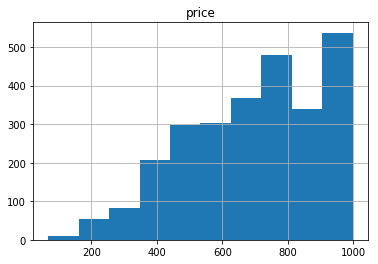

In [307]:
dat2 = df_price_column_selected.toPandas()
dat2.hist(column='price')

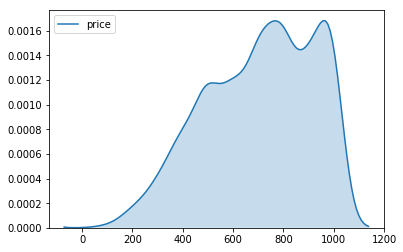

In [308]:
sb.kdeplot(dat2.price, shade =True)

In [314]:
df_review_ratings = df1.dropna(subset=('review_scores_rating','price'))

In [316]:
df_review_ratings.show(10)

+---------+-------------------------+-----------------+-------------+--------------------+----------+-----+
|     city|host_total_listings_count|    property_type|neighbourhood|review_scores_rating|host_since|price|
+---------+-------------------------+-----------------+-------------+--------------------+----------+-----+
|Stockholm|                      2.0|        Apartment|    Södermalm|                97.0|2011-07-06|597.0|
|Stockholm|                      1.0|        Apartment|    Södermalm|                93.0|2011-07-13|734.0|
|Stockholm|                      1.0|Bed and breakfast|    Södermalm|                98.0|2011-08-26|665.0|
|Stockholm|                      1.0|        Apartment|  Kungsholmen|                93.0|2011-02-27|597.0|
|Stockholm|                      2.0|        Apartment|    Södermalm|                97.0|2011-07-06|558.0|
|Stockholm|                      3.0|        Townhouse|Rinkeby-Kista|                89.0|2011-11-02|196.0|
|Stockholm|                 

In [319]:
#df.withColumn('RealFare', f.col('Fare')/(f.col('SibSp')+f.col('Parch')+1)).select('SibSp', 'Parch', 'Fare', 'RealFare').show()
df_value = df_review_ratings.withColumn('value', f.col('review_scores_rating')/f.col('price')).select('neighbourhood', 'value')

In [320]:
df_value.show(10)

+-------------+-------------------+
|neighbourhood|              value|
+-------------+-------------------+
|    Södermalm| 0.1624790619765494|
|    Södermalm|0.12670299727520437|
|    Södermalm|0.14736842105263157|
|  Kungsholmen|0.15577889447236182|
|    Södermalm|0.17383512544802868|
|Rinkeby-Kista|0.45408163265306123|
|Rinkeby-Kista| 0.4088888888888889|
|       Farsta|0.22384428223844283|
|Rinkeby-Kista| 0.3299319727891156|
|       Älvsjö|0.12217795484727756|
+-------------+-------------------+
only showing top 10 rows



In [326]:
#Creating the window
df_window = Window.partitionBy('neighbourhood').orderBy(f.desc('value'))

In [327]:
df_rank = df_value.withColumn('NeighbourhoodValue', f.rank().over(df_window))

In [328]:
df_rank_top_3 = df_rank.filter(f.col('NeighbourhoodValue') <= 3).drop('NeighbourhoodValue').orderBy('neighbourhood', f.desc('value')).show()

+-------------------+------------------+
|      neighbourhood|             value|
+-------------------+------------------+
|               null|             100.0|
|               null|13.714285714285714|
|               null|              12.5|
|16th Street Heights|3.1666666666666665|
|16th Street Heights| 2.857142857142857|
|16th Street Heights| 2.857142857142857|
|16th Street Heights| 2.857142857142857|
| 1st Arrondissement|10.333333333333334|
| 1st Arrondissement| 8.181818181818182|
| 1st Arrondissement| 8.166666666666666|
| 2nd Arrondissement|              6.25|
| 2nd Arrondissement|            5.9375|
| 2nd Arrondissement|5.2631578947368425|
| 3rd Arrondissement| 7.142857142857143|
| 3rd Arrondissement| 6.666666666666667|
| 3rd Arrondissement| 6.666666666666667|
| 4th Arrondissement| 7.071428571428571|
| 4th Arrondissement|              6.25|
| 4th Arrondissement|               6.0|
| 4th Arrondissement|               6.0|
+-------------------+------------------+
only showing top

##Trends
There are various reviews and most of the them are for specific features about the apartment being listed. We are assuming that the review_scores_rating reflects or serves as the overall perception of customers about the listings. 

In [332]:
#Select the price attribute
df_review_column_selected = df_selected_city.select('review_scores_rating').dropna()

### Describe the data
List the features (schema) and sizes of the datasets.

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

## Prices
Compute the minimum, maximum and average listing price in your city. 

Compute and visualize the distribution of listing prices in your city.

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.